In [1]:
from pulse2percept.models import AxonMapModel, BiphasicAxonMapModel, BiphasicAxonMapSpatial, Model, AxonMapSpatial
from pulse2percept.stimuli import Stimulus, BiphasicPulseTrain
from pulse2percept.implants import DiskElectrode, ProsthesisSystem, ArgusII, ElectrodeArray

import numpy as np
# import jax.numpy as np
import jax
from jax import jit

## Where the magic happens (Jax predict_percept())

In [2]:
"""
Function to be JIT'ed. 
Must be purely functional, and follow all rules at https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html

"""
def gpu_biphasic_axon_map(amps, freqs, pdurs, x, y, # Per ACTIVE electrode
                          axon_segments, idx_start, idx_end, # ith segment goes from axon_segments[idx_start[i] : idx_end[i]]
                          rho, axlambda, thresh_percept, timesteps):
  deg2rad = 3.14159265358979323846 / 180.0

  n_space = len(idx_start)

  min_size = 10**2 / rho**2
  min_streak = 10**2 / axlambda **2

  # First get contributions from F, G, H per electrode
  scaled_amps = amps / (0.8825 + 0.27*pdurs)
  brights = 1.84*scaled_amps + 0.2*freqs + 2.0986
  sizes = np.maximum(1.081*scaled_amps - 0.3533764, min_size)
  streaks = np.maximum(1.56 - 0.54 * pdurs ** 0.21, min_streak)

  I = np.zeros(shape=(n_space), dtype=np.float32)

  for idx_space in range(n_space):
    # (n_segments, n_elecs)
    d2_el = ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 0])[:, None] - x[None, :])**2. + ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 1])[:, None] - y[None, :])**2. 

    # (n_segments, n_elecs)
    electrode_intensities = brights * np.exp(-d2_el / ( 2. * rho**2. * sizes)) * ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 2])[:, None] ** (1. / streaks)[None, :])
    #                      (n_elec) * (n_segments, n_elecs)                  * (n_segments, n_elecs)

    # (n_segments)
    axon_intensities = np.sum(electrode_intensities, axis=1) # ith row is intensity at ith axon segment

    # axon_intensities = jax.ops.index_update(axon_intensities, (axon_intensities < thresh_percept), 0.0)

#     I = jax.ops.index_update(I, idx_space, np.max(axon_intensities))
    I[idx_space] = np.max(axon_intensities)

  return np.asarray(np.transpose(np.tile(I, (timesteps, 1))))


#### Build model here in new spatial subclass, wrapped in BiphasicAxonMapGPU

In [3]:
class BiphasicAxonMapGPUSpatial(AxonMapSpatial):
  def __init__(self, **params):
    super(BiphasicAxonMapGPUSpatial, self).__init__(**params)


  def _predict_spatial(self, earray, stim):
    assert isinstance(earray, ElectrodeArray)
    assert isinstance(stim, Stimulus)

    # get relevant stimulus properties
    amps = np.array([stim.metadata['electrodes'][str(e)]['metadata']['amp'] for e in stim.electrodes], dtype="float32")
    freqs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['freq'] for e in stim.electrodes], dtype="float32")
    pdurs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['phase_dur'] for e in stim.electrodes], dtype="float32")


    return gpu_biphasic_axon_map(amps, freqs, pdurs,
                                 np.array([earray[e].x for e in stim.electrodes], dtype=np.float32),
                                 np.array([earray[e].y for e in stim.electrodes], dtype=np.float32),
                                 self.axon_contrib,
                                 self.axon_idx_start.astype(np.uint32),
                                 self.axon_idx_end.astype(np.uint32),
                                 self.rho, self.axlambda, self.thresh_percept, stim.shape[1])


class BiphasicAxonMapGPU(Model):
  def __init__(self, **params):
    super(BiphasicAxonMapGPU, self).__init__(spatial=BiphasicAxonMapGPUSpatial(), temporal=None, **params)

  def predict_percept(self, implant, t_percept=None):
    # Make sure stimulus is a BiphasicPulseTrain:
    if not isinstance(implant.stim, BiphasicPulseTrain):
      # Could still be a stimulus where each electrode has a biphasic pulse train
      for ele, params in implant.stim.metadata['electrodes'].items():
        if params['type'] != BiphasicPulseTrain or params['metadata']['delay_dur'] != 0: 
          raise TypeError("All stimuli must be BiphasicPulseTrains with no delay dur (Failing electrode: %s)" % (ele)) 
        
    return super(BiphasicAxonMapGPU, self).predict_percept(implant, t_percept=t_percept)


In [4]:
model = BiphasicAxonMapGPU()
model.build()
implant = ArgusII()
stim = Stimulus({"A2" : BiphasicPulseTrain(20, 1, 0.45)})
implant.stim = stim

model_orig = BiphasicAxonMapModel()
model_orig.build()
print()

BiphasicAxonMapModel(ax_segments_range=(0, 50), 
                     axlambda=200, 
                     axon_pickle='axons.pickle', 
                     axons_range=(-180, 180), 
                     bright_model=DefaultBrightModel, 
                     do_thresholding=False, 
                     engine='serial', eye='RE', 
                     grid_type='rectangular', 
                     ignore_pickle=False, 
                     loc_od=(15.5, 1.5), 
                     min_ax_sensitivity=0.001, 
                     n_ax_segments=500, n_axons=1000, 
                     n_jobs=1, rho=200, 
                     scheduler='threading', 
                     size_model=DefaultSizeModel, 
                     spatial=BiphasicAxonMapSpatial, 
                     streak_model=DefaultStreakModel, 
                     temporal=None, thresh_percept=0, 
                     verbose=True, xrange=(-15, 15), 
                     xystep=0.25, yrange=(-15, 15))

426 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


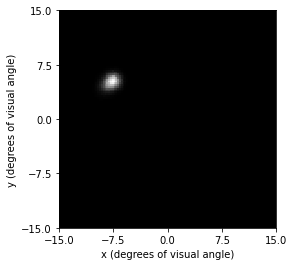

In [5]:
%%timeit 
percept = model.predict_percept(implant)
percept.plot()

In [6]:
%%timeit
p1 = model_orig.predict_percept(implant)
p1.plot()

NameError: name 'fast_biphasic_axon_map' is not defined

In [ ]:
np.max(percept.data - p1.data)

NameError: ignored

## NUMPY

In [ ]:
# numpy copy
"""
Function to be JIT'ed. 
Must be purely functional, and follow all rules at https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html

"""
def gpu_biphasic_axon_map(amps, freqs, pdurs, x, y, # Per ACTIVE electrode
                          axon_segments, idx_start, idx_end, # ith segment goes from axon_segments[idx_start[i] : idx_end[i]]
                          rho, axlambda, thresh_percept, timesteps):
  deg2rad = 3.14159265358979323846 / 180.0

  n_space = len(idx_start)

  min_size = 10**2 / rho**2
  min_streak = 10**2 / axlambda **2

  # First get contributions from F, G, H per electrode
  scaled_amps = amps / (0.8825 + 0.27*pdurs)
  brights = 1.84*scaled_amps + 0.2*freqs + 2.0986
  sizes = np.maximum(1.081*scaled_amps - 0.3533764, min_size)
  streaks = np.maximum(1.56 - 0.54 * pdurs ** 0.21, min_streak)

  I = np.zeros(shape=(n_space), dtype=np.float32)

  for idx_space in range(n_space):
    # (n_segments, n_elecs)
    d2_el = ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 0])[:, None] - x[None, :])**2. + ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 1])[:, None] - y[None, :])**2. 

    # (n_segments, n_elecs)
    electrode_intensities = brights * np.exp(-d2_el / ( 2. * rho**2. * sizes)) * ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 2])[:, None] ** (1. / streaks)[None, :])
    #                      (n_elec) * (n_segments, n_elecs)                  * (n_segments, n_elecs)

    # (n_segments)
    axon_intensities = np.sum(electrode_intensities, axis=1) # ith row is intensity at ith axon segment

    axon_intensities[axon_intensities < thresh_percept] = 0.0

    I[idx_space] = np.max(axon_intensities)

  return np.asarray(np.transpose(np.tile(I, (timesteps, 1))))

# The IP address the notebook server will listen on.
c.NotebookApp.ip = '*'
# The port the notebook server will listen on.
c.NotebookApp.port = 8888
# The full path to an SSL/TLS certificate file.
c.NotebookApp.certfile = u'/home/mbeyeler/localhost.pem'
# The string should be of the form type:salt:hashed-password.
c.NotebookApp.password = u'sha1:b530c25cfd69:d259fe693010a32b343584091a105a6ade576291' # <= You'll need to replace with the results of creating a password with IPython!
# Whether to open in a browser after starting. The specific browser used is
# platform dependent and determined by the python standard library `webbrowser`
# module, unless it is overridden using the --browser (NotebookApp.browser)
# configuration option.
c.NotebookApp.open_browser = False
~/.jupyter/jupyter_notebook_config.py
